In [300]:
###############################################################################
# Calculating forces on hydrodynamically and acoustically interacting spheres
# in the Rayleigh limit
# Methods based on Multibody Dynamics in Acoustophoresis (Baasch et al.)
import numpy as np
import pylab as plt
%matplotlib inline 
from matplotlib import animation, rc
from IPython.display import HTML

## Fix:
# interparticle distances aren't taking periodic BCs into account (should this even use periodic BCs?)
# Periodic BCs disabled for now, search for % characters to check
# find a reasonable unit system
# check counting for pairwise interactions, loops that explicitly avoid double-counting need to 
#    also make sure that both reciprocal forces are calculated

# Calculate physical quantities for the system and non-dimensionalize appropriately
# First calculate everything in SI units:
density_medium = 1000
soundspeed_medium =1480
density_particle = 1180
soundspeed_particle = 1480*1.1 # not known

compress_medium = 1/(density_medium*soundspeed_medium**2)
compress_particle = 1/(density_particle*soundspeed_particle**2)

compress_ratio = compress_particle/compress_medium
density_ratio = density_particle/density_medium

f0 = 1 - compress_ratio
f1 = 2*(density_ratio-1)/(2*density_ratio+1)
f0s = f0
f0p = f0
f1s = f1
f1p = f1 # all particles identical
contrast_factor = f0 + (3/2)*f1 # check this

radius = 2*10**(-6)
frequency = 2*10**6
wavelength = soundspeed_medium/frequency
wavenumber = 2*np.pi/wavelength

dynamic_viscosity = 8.9 *10**(-4) # Pa*s
viscosity = dynamic_viscosity
acoustic_energy_density = 1000 # Figure out

resonator_height = 350*10**(-6)
resonator_width = 20*10**(-3) # diameter

length_scale = 1 
time_scale = 1
mass_scale = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in double_scalars


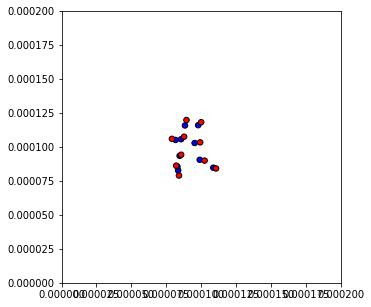

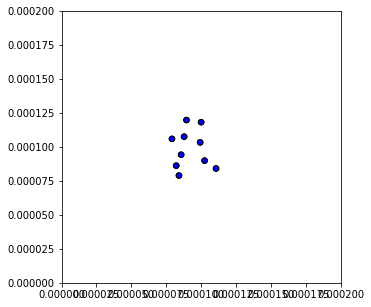

In [311]:
num_particles = 10

particle_vel = np.zeros((num_particles,3))
max_iterations = 100 # for checking particle overlap at each timestep
overlap_tol = .01*radius # tolerance for overlapping particles to not repeatedly run excluded volume check

standing_wave_amplitude = 4*np.pi*radius**3*acoustic_energy_density*wavenumber*contrast_factor
Omega_a_squared = 0*    1*10**-6 # vortex strength



def force_grav(rho_p,rho_m,radius):
    g = 9.81
    volume = 4/3 * np.pi * radius**3
    force = (rho_m-rho_p)*volume*g
    return force

def initialize_pos(x_range, y_range, z_range):
    particle_pos = np.zeros((num_particles,3))
    x_center = (x_range[0]+x_range[1])/2
    y_center = (y_range[0]+y_range[1])/2
    z_center = (z_range[0]+z_range[1])/2
    
    spread = 0.2
    for i in range(num_particles):
        particle_pos[i,0] = np.random.uniform(low=x_center*(1-spread), high=x_center*(1+spread))
        particle_pos[i,1] = np.random.uniform(low=y_center*(1-spread), high=y_center*(1+spread))
        particle_pos[i,2] = np.random.uniform(low=z_center*(1-spread), high=z_center*(1+spread))
        particle_pos[i,2]=z_center
    return particle_pos

# Update positions and velocities, applying periodic BCs
def update_pos(particle_pos, particle_vel, timestep):
    new_pos = particle_pos + particle_vel*timestep
    new_pos = wall_collide(new_pos)
    new_pos = exclude_volume(new_pos,timestep,radius)
    new_vel = 0
    # Sum external forces, find their contribution to the flow everywhere
    force1 = standing_wave_arf(new_pos)
    force2 = 6*np.pi*viscosity*radius*vortex(new_pos)[0,:,:]
    force3 = bjerknes_total(new_pos)
    total_force = force1 + force2 +force3
    new_vel += hydro_interact(particle_pos,total_force)
#     new_pos = new_pos % (x_size,y_size,z_size)
    return new_pos, new_vel

# Excluded volume interaction
def exclude_volume(particle_pos, timestep, radius):
    # Loops for pairwise checking without self- or double-counting
    num_iterations = 0
    while num_iterations < max_iterations:
        num_iterations += 1
        num_overlaps = 0
        for i in range(0,num_particles-1):
            for j in range(i+1,num_particles):
                distance_vector = particle_pos[i,:]-particle_pos[j,:]
                distance = np.sqrt(np.sum(distance_vector**2))
                overlap_length = 2*radius-distance
                if overlap_length >overlap_tol:
                    num_overlaps += 1
                    particle_pos[i,:]+= distance_vector/np.linalg.norm(distance_vector) * overlap_length/2
                    particle_pos[j,:]-= distance_vector/np.linalg.norm(distance_vector) * overlap_length/2
                    # 
#                     # re-apply periodic BCs while doing this
#                     particle_pos[i,:] = particle_pos[i,:] % (x_size, y_size, z_size)
#                     particle_pos[j,:] = particle_pos[j,:] % (x_size, y_size, z_size)
#         if num_iterations == max_iterations -1:
#             print('Could not exclude all particles within max num of iterations')
        if num_overlaps == 0:
            break
    return particle_pos

def wall_collide(particle_pos):
    for i in range(num_particles):
        if particle_pos[i,2] < z_range[0]+radius:
            particle_pos[i,2] = z_range[0]+radius
        if particle_pos[i,2] > z_range[1]-radius:
            particle_pos[i,2] = z_range[1]-radius
    return particle_pos

# Calculate flow contribution from all external forces
def hydro_interact(particle_pos, total_force):
    # Hydrodynamic interaction matrix: NxN matrix with a 3x3 submatrix in each entry
    interaction_matrix = np.zeros((num_particles,num_particles,3,3))
    # Construct the matrix
    for i in range(num_particles):
        for j in range(num_particles):
            if i == j:
                interaction_matrix[i,j,:,:] = np.identity(3)
            else:
                ri = particle_pos[i,:]
                rj = particle_pos[j,:]
                interaction_matrix[i,j,:,:] = cij_mat(ri,rj)
    # Multiply with force vector to get flow vector
    resultant_flow = np.zeros((num_particles,3))
    for i in range(num_particles):
        for j in range(num_particles):
            resultant_flow[i,:] += np.matmul(interaction_matrix[i,j,:,:], total_force[j])
    return resultant_flow
            
def cij_mat(particle_pos1, particle_pos2):
    rij = particle_pos1 - particle_pos2
    r = np.linalg.norm(rij)
    a = radius
    mu = viscosity
    rr_mat = np.outer(rij,rij)
    term1 = (3*a/4) * (np.identity(3)/r + rr_mat/r**3)
    term2 = (a**3)/4 * (np.identity(3)/r**3 - 3*rr_mat/r**5)
    prefactor = 1/(6*np.pi*mu*a)
    return prefactor*(term1 + term2)

# Primary acoustic radiation force from a standing wave
def standing_wave_arf(particle_pos):
    # Make a standing wave with one nodal plane at z_range/2
    force = np.zeros((num_particles,3))
    z_pos = np.asarray(particle_pos[:,2])
    z_center = (z_range[1]+z_range[0])/2
    # Only give force within limits of the resonator
    for i in range(num_particles):
        if z_range[0]<z_pos[i]<z_range[1]: 
            force[i,2] = -standing_wave_amplitude*np.sin(2*wavenumber*(z_pos[i]-z_center))
    return force

# Place a vortex line along the y-axis
def vortex(particle_pos):
    # calculate x,z from center of window, which is x_size/2, z_size/2, NOT (0,0)
    x_pos = particle_pos[:,0]-x_size/2
    z_pos = particle_pos[:,2]-z_size/2
    x_hat = np.array([1,0,0])
    z_hat = np.array([0,0,1])
    r_pos = np.sqrt(x_pos**2 + z_pos**2)
    phi_hat = (-x_pos[:,None]*z_hat[None,:] + z_pos[:,None]*x_hat[None,:])/(r_pos[:,None])
    return Omega_a_squared/r_pos[:,None] * phi_hat[None,:]

# Acoustic interaction/secondary forces in a plane standing wave aligned in z
def bjerknes_total(particle_pos):
    # Sum interaction forces between all pairs of particles
    bjerknes_force = np.zeros((num_particles,3))
    for i in range(0,num_particles):
        for j in range(num_particles):
            if i != j:
                bjerknes_force[j,:] += bjerknes_single(particle_pos[i,:], particle_pos[j,:])
    return bjerknes_force

def bjerknes_single(particle_pos1, particle_pos2):
    # Calculate the acoustic interaction force between a specific pair of particles.   
    # Force calculated in Mathematica from potential given in Silva, Bruus, 2014
    # Given in spherical coordinates (R,theta) (axisymmetric, no phi dependence) with 
    # z along the standing wave axis. H is the distance from the first standing wave node to 
    # the coordinate origin
    # The expression is cumbersome and should be double-checked
    # or simplified for small R or H IF appropriate 
    a_p = radius
    a_s = radius # all particles are the same size 
    k = wavenumber
    E0 = acoustic_energy_density
    # Particle1 is the scatterer exerting force on Particle2
    x, y, z = particle_pos2 - particle_pos1
    R = np.linalg.norm(particle_pos2 - particle_pos1) * wavenumber
    H = particle_pos1[2] * wavenumber

    theta = np.arctan(np.sqrt(x**2+y**2)/z)
    phi = np.arctan(y/x)
    
    r_component = -(np.pi*a_p**3*a_s**3*E0*k**4)/(18*R**4)\
                    *(f0s*R*np.sin(H)\
                      *(np.cos(theta)*np.cos(H-R*np.cos(theta))\
                      *(np.cos(R)*(8*f0p*R**2+3*f1p*(R**2-8))-15*f1p*R*np.sin(R))\
                      +R*np.sin(H-R*np.cos(theta))*(4*np.cos(R)*(2*f0p+3*f1p*np.cos(theta)**2)\
                                                    +R*np.sin(R)*(8*f0p+3*f1p*np.cos(theta)**2)))\
    +3*f1s*np.cos(H)*(np.cos(H-R*np.cos(theta))*(R*np.sin(R)*(4*f0p*R**2*np.cos(theta)**2+3*f1p*((R**2-9)*np.cos(2*theta)+R**2-1))\
                                                 +4*f0p*R**2*np.cos(theta)**2*np.cos(R)+3*f1p*np.cos(R)*((4*R**2-9)*np.cos(2*theta)+R**2-3)-6*f1p*R)\
                      +R*np.cos(theta)*np.sin(H-R*np.cos(theta))*(np.cos(R)*(R**2*(-(4*f0p+3*f1p))+8*f0p-3*f1p*(R**2-3)*np.cos(2*theta)+3*f1p)\
                                                                   +R*(np.sin(R)*(8*f0p+9*f1p*np.cos(2*theta))+3*f1p))))
    
    st = np.sin(theta)
    ct = np.cos(theta)
    ch = np.cos(H)
    sh = np.sin(H)
    sr = np.sin(R)
    cr = np.cos(R)
    chrct = np.cos(H-R*ct)
    shrct = np.sin(H-R*ct)
    
    theta_component = (np.pi*a_p**3*a_s**3*E0*k**4)/(18*R**4)\
                    *(3*R*st*(sr*chrct*(4*f1s*ct*ch*(f0p*R**2+9*f1p)+f0s*f1p*R*sh)+R*shrct*(f1s*ch*(sr*(9*f1p*np.cos(2*theta)-4*f0p)+3*f1p)\
                                                                                            +f0s*f1p*R*ct*sh*sr))\
    +cr*(2*chrct*(2*f0s*R*st*sh*(2*f0p*R**2+3*f1p)+3*f1s*np.sin(2*theta)*ch*(R**2*(f0p-3*f1p)+9*f1p))\
    +3*R*st*shrct*(4*f0s*f1p*R*ct*sh-f1s*ch*(4*f0p*3*f1p*(R**2-3)*np.cos(2*theta)+3*f1p*(R**2-1)))))
    
    # Convert back to Cartesian:
    x_hat, y_hat, z_hat = np.array([1,0,0]) , np.array([0,1,0]) , np.array([0,0,1]) 
    r_hat = (x*x_hat + y*y_hat + z*z_hat)/np.sqrt(x**2+y**2+z**2)
    theta_hat =((x*x_hat + y*y_hat)*z - (x**2+y**2)*z_hat)/(np.sqrt(x**2+y**2+z**2)*np.sqrt(x**2+y**2))
    force_cartesian = r_component*r_hat + theta_component*theta_hat
    
    return force_cartesian

def run(time_max,timestep):
    times = []
    positions = []
    velocities = []
    particle_pos = initialize_pos(x_range,y_range,z_range)
    particle_vel = np.zeros((num_particles,3))
    num_steps = int(time_max/timestep)
    for i in range(num_steps):
        times.append(timestep*i)
        positions.append(particle_pos)
        velocities.append(particle_vel)
        particle_pos, particle_vel = update_pos(particle_pos,particle_vel,timestep)
    return times, positions, velocities

x_range = [0,resonator_width*.01]
y_range = [0,resonator_width*.01]
z_range = [0,resonator_height]
x_size = x_range[1]-x_range[0]
y_size = y_range[1]-y_range[0]
z_size = z_range[1]-z_range[0]

total_steps = 2500
time_step = .5*10**(-4)
times, positions, velocities = run(total_steps*time_step, time_step)

positions = np.asarray(positions)
velocities = np.asarray(positions)

# Plot system at start and end
fig, axes = plt.subplots(figsize=(5,5))
axes.set_xlim(x_range)
axes.set_ylim(y_range)
for i in range(num_particles):
    circle_start = plt.Circle((positions[0,i,0], positions[0,i,1]), radius, color='blue', ec='black')
    circle_end = plt.Circle((positions[-1,i,0], positions[-1,i,1]), radius, color='red', ec='black')
    axes.add_artist(circle_start)
    axes.add_artist(circle_end)
    
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(x_range)
ax.set_ylim(y_range)

circle_dict = {}
x_pos = positions[:,:,0]
y_pos = positions[:,:,1]
z_pos = positions[:,:,2]
z_center = (z_range[1]-z_range[0])/2
# alphas = np.exp(-(z_pos-z_center)**2/10)
alphas = np.ones((total_steps,num_particles)) # place holder
for n in range(num_particles):
    circle_dict["circle"+str(n)] = plt.Circle((x_pos[0,n],y_pos[0,n]),radius,fc='b',ec='k', alpha=alphas[0,n])


def init():
    for n in range(num_particles):
        circle_dict["circle"+str(n)].center = (x_pos[0,n],y_pos[0,n])
        circle_dict["circle"+str(n)].set_alpha(alphas[0,n])
        ax.add_patch(circle_dict["circle"+str(n)])
    return circle_dict.values()

def animate(i):
    for n in range(num_particles):
        circle_dict["circle"+str(n)].center = (x_pos[i,n],y_pos[i,n])
        circle_dict["circle"+str(n)].set_alpha(alphas[i,n])
    return circle_dict.values()
anim_step=2
num_steps = len(positions[:,0,0])
frame_list = np.arange(0,num_steps,anim_step)
anim=animation.FuncAnimation(fig,animate,init_func=init,frames=frame_list,interval = 42,blit=True)

HTML(anim.to_html5_video())



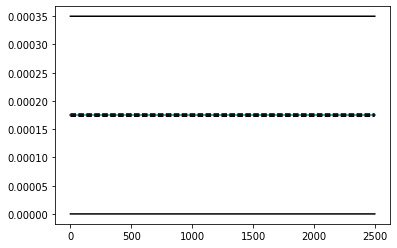

In [310]:
for n in range(num_particles):
    plt.plot(z_pos[:,n])
plt.plot(z_pos[:,n]*0 + z_range[1],'k')
plt.plot(z_pos[:,n]*0 + z_range[0],'k')
plt.plot(z_pos[:,n]*0 + z_center, 'k--')
plt.plot(z_pos[:,n]*0 + z_center+radius, 'k--')
plt.plot(z_pos[:,n]*0 + z_center-radius, 'k--')

In [ ]:
# Get particles to form cluster in plane in the absence of a vortex. Check calculations
# Check bjerknes force calculation for any errors

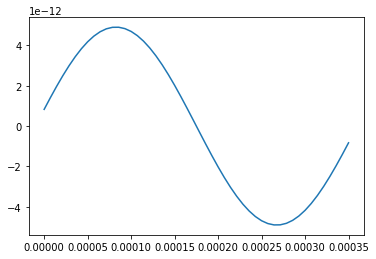

In [274]:
z_pos = np.linspace(0,z_range[1])
plt.plot(z_pos,-standing_wave_amplitude*np.sin(2*wavenumber*(z_pos-z_center)))